In [1]:
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q transformers accelerate sentencepiece
!pip install -q timm einops
!pip install -q segment-anything

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os

os.listdir("/kaggle/input/sam-checkpoint")


['sam_vit_b_01ec64.pth']

# Import Image

(np.float64(-0.5), np.float64(1919.5), np.float64(1439.5), np.float64(-0.5))

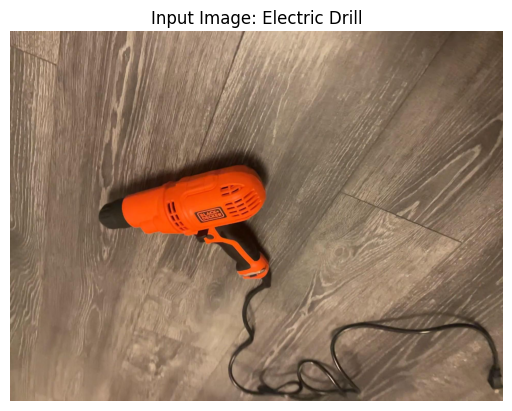

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

IMAGE_PATH = "/kaggle/input/drill-image/000651.jpg"

image = Image.open(IMAGE_PATH).convert("RGB")

plt.imshow(image)
plt.title("Input Image: Electric Drill")
plt.axis("off")


# Load CLIP for affordance recognition

In [4]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 152MiB/s]


# Define affordance for the drill image

In [5]:
affordance_prompts = [
    "an object that can be grasped by a robot",
    "a tool used for drilling holes",
    "an object that can rotate to cut material",
    "an object that requires pressing a trigger",
    "a handheld power tool",
    "an object that can fasten screws",
    "an object that should be held firmly during use"
]


# Compute the affordance score

In [6]:
image_input = clip_preprocess(image).unsqueeze(0).to(device)
text_input = clip.tokenize(affordance_prompts).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(image_input)
    text_features = clip_model.encode_text(text_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (image_features @ text_features.T).softmax(dim=-1)

affordance_scores = {
    affordance_prompts[i]: similarity[0][i].item()
    for i in range(len(affordance_prompts))
}

affordance_scores


{'an object that can be grasped by a robot': 0.14013671875,
 'a tool used for drilling holes': 0.142822265625,
 'an object that can rotate to cut material': 0.1405029296875,
 'an object that requires pressing a trigger': 0.142578125,
 'a handheld power tool': 0.14990234375,
 'an object that can fasten screws': 0.14208984375,
 'an object that should be held firmly during use': 0.1419677734375}

# Load SAM for region recognition

In [7]:
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

SAM_CHECKPOINT = "/kaggle/input/sam-checkpoint/sam_vit_b_01ec64.pth"

sam = sam_model_registry["vit_b"](checkpoint=SAM_CHECKPOINT)
sam.to(device)

mask_generator = SamAutomaticMaskGenerator(sam)


# Generate Masks

In [9]:
image_np = np.array(image)
masks = mask_generator.generate(image_np)

print("Total masks generated:", len(masks))

Total masks generated: 7


# Region-Level Affordance (CLIP + SAM)

In [11]:
def crop_from_mask(image, mask):
    ys, xs = np.where(mask)
    if len(xs) == 0:
        return None, None
    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    return image.crop((x1, y1, x2, y2)), (x1, y1, x2, y2)


## Compute Region Affordances# 

In [12]:
region_results = []

for i, m in enumerate(masks[:6]):  # top 6 regions
    crop, bbox = crop_from_mask(image, m["segmentation"])
    if crop is None:
        continue

    crop_input = clip_preprocess(crop).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = clip_model.encode_image(crop_input)
        feat /= feat.norm(dim=-1, keepdim=True)
        scores = (feat @ text_features.T).softmax(dim=-1)

    best_affordance = affordance_prompts[scores.argmax()]
    confidence = scores.max().item()

    region_results.append({
        "bbox": bbox,
        "affordance": best_affordance,
        "confidence": confidence
    })

region_results


[{'bbox': (np.int64(0), np.int64(4), np.int64(1919), np.int64(1434)),
  'affordance': 'a handheld power tool',
  'confidence': 0.1492919921875},
 {'bbox': (np.int64(0), np.int64(0), np.int64(194), np.int64(128)),
  'affordance': 'an object that can rotate to cut material',
  'confidence': 0.1448974609375},
 {'bbox': (np.int64(345), np.int64(651), np.int64(470), np.int64(770)),
  'affordance': 'an object that can rotate to cut material',
  'confidence': 0.1439208984375},
 {'bbox': (np.int64(718), np.int64(684), np.int64(842), np.int64(745)),
  'affordance': 'an object that should be held firmly during use',
  'confidence': 0.1461181640625},
 {'bbox': (np.int64(355), np.int64(430), np.int64(399), np.int64(606)),
  'affordance': 'an object that should be held firmly during use',
  'confidence': 0.14453125},
 {'bbox': (np.int64(767), np.int64(974), np.int64(835), np.int64(1087)),
  'affordance': 'an object that should be held firmly during use',
  'confidence': 0.14599609375}]

# Implement BLIP-1 for Physical Property Reasoning

In [13]:
!pip install -q transformers accelerate sentencepiece timm

## Load BLIP-1 due to resource limitation

In [14]:
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
blip_model = BlipForQuestionAnswering.from_pretrained(
    "Salesforce/blip-vqa-base"
).to(device)


2026-01-14 14:47:18.699648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768402038.874222      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768402038.923743      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768402039.337804      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768402039.337832      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768402039.337835      55 computation_placer.cc:177] computation placer alr

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

## Physical Questions

In [16]:
physical_questions = [
    "Is this object powered by electricity?",
    "Does this object have moving parts?",
    "Is this object safe to touch while operating?",
    "Can this object cause harm if misused?",
    "Is this object designed to be held by hand?"
]


## Run BLIP for physical reasoning

In [17]:
physical_properties = {}

for question in physical_questions:
    inputs = processor(
        image,
        question,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        output = blip_model.generate(
            **inputs,
            max_new_tokens=6
        )

    answer = processor.decode(output[0], skip_special_tokens=True)
    physical_properties[question] = answer

physical_properties


{'Is this object powered by electricity?': 'yes',
 'Does this object have moving parts?': 'yes',
 'Is this object safe to touch while operating?': 'no',
 'Can this object cause harm if misused?': 'yes',
 'Is this object designed to be held by hand?': 'no'}

# Affordance precision

In [18]:
ground_truth_affordances = {
    "an object that can be grasped by a robot",
    "a tool used for drilling holes",
    "an object that can rotate to cut material"
}

predicted = sorted(
    affordance_scores.items(),
    key=lambda x: x[1],
    reverse=True
)[:3]

predicted_affordances = {p[0] for p in predicted}

precision = len(predicted_affordances & ground_truth_affordances) / len(predicted_affordances)
recall = len(predicted_affordances & ground_truth_affordances) / len(ground_truth_affordances)

precision, recall


(0.3333333333333333, 0.3333333333333333)

# Visualization (Bounding Boxes + Labels)

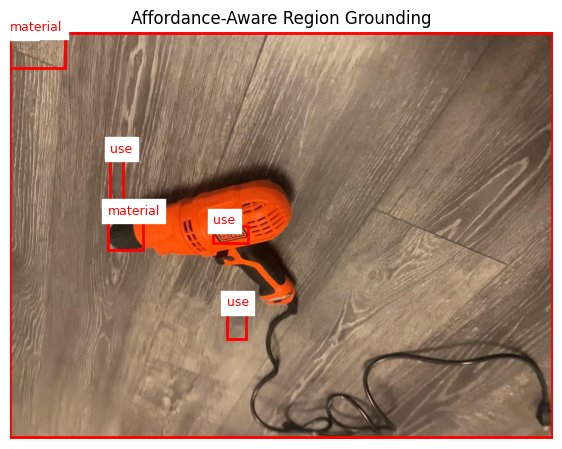

In [19]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(7,7))
ax.imshow(image)

for r in region_results:
    x1, y1, x2, y2 = r["bbox"]
    rect = patches.Rectangle(
        (x1, y1), x2-x1, y2-y1,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(
        x1, y1-5,
        r["affordance"].split(" ")[-1],
        color="red",
        fontsize=9,
        backgroundcolor="white"
    )

plt.title("Affordance-Aware Region Grounding")
plt.axis("off")
plt.show()


In [21]:
final_output = {
    "object": "electric drill",
    "affordances": predicted_affordances,
    "physical_properties": physical_properties,
    "precision": precision,
    "recall": recall
}

final_output


{'object': 'electric drill',
 'affordances': {'a handheld power tool',
  'a tool used for drilling holes',
  'an object that requires pressing a trigger'},
 'physical_properties': {'Is this object powered by electricity?': 'yes',
  'Does this object have moving parts?': 'yes',
  'Is this object safe to touch while operating?': 'no',
  'Can this object cause harm if misused?': 'yes',
  'Is this object designed to be held by hand?': 'no'},
 'precision': 0.3333333333333333,
 'recall': 0.3333333333333333}

## USE LLaVA for Manipulation Instruction Generation

In [1]:
!pip install -U \
  protobuf>=5.26.1 \
  transformers==4.45.2 \
  tokenizers>=0.20 \
  accelerate \
  sentencepiece \
  einops


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 6.33.4 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.4 which is incompatible.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.4 which is incompatible.
grpcio-status 1.71

In [3]:
from PIL import Image
import torch
from transformers import LlavaProcessor, LlavaForConditionalGeneration

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

image = Image.open("/kaggle/input/drill-image/000651.jpg").convert("RGB")

In [6]:
model_id = "llava-hf/llava-1.5-7b-hf"

llava_processor = LlavaProcessor.from_pretrained(model_id)
llava_model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

llava_model.eval()
print("LLaVA loaded successfully on Kaggle")

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LLaVA loaded successfully on Kaggle


(np.float64(-0.5), np.float64(1919.5), np.float64(1439.5), np.float64(-0.5))

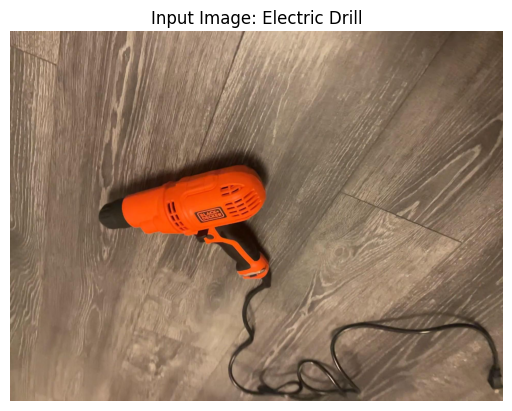

In [29]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "/kaggle/input/drill-image/000651.jpg"

image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.title("Input Image: Electric Drill")
plt.axis("off")

In [45]:
import torch
from PIL import Image
from transformers import LlavaProcessor, LlavaForConditionalGeneration

In [46]:
demo_data = [
    {
        "image": "/kaggle/input/drill-image/000651.jpg",
        "conversations": [
            {"from": "human", "value": "handle of a power drill"}
        ]
    },
    {
        "image": "/kaggle/input/drill-image/000651.jpg",
        "conversations": [
            {"from": "human", "value": "grasp for drilling holes"}
        ]
    }
]

In [52]:
def run_demo(example, llava_model, llava_processor):
    """
    Runs a single ManipVQA-style demo example using LLaVA
    """
    # 1. Load image
    image = Image.open(example["image"]).convert("RGB")

    # 2. Extract the human question
    question = example["conversations"][0]["value"]

    # 3. Build ManipVQA-style prompt
    prompt = f"""
USER: <image>
Please provide bounding box coordinates of the {question}.
Return coordinates in normalized format [x1, y1, x2, y2].
ASSISTANT:
"""

    # 4. Convert to model inputs
    inputs = llava_processor(
        text=prompt,
        images=image,
        return_tensors="pt"
    ).to("cuda")

    # 5. Run inference
    with torch.no_grad():
        outputs = llava_model.generate(
            **inputs,
            max_new_tokens=80,
            do_sample=False
        )

    # 6. Decode output
    response = llava_processor.decode(outputs[0], skip_special_tokens=True)
    print(response)

    return response


In [53]:
for i, example in enumerate(demo_data):
    print(f"\n--- Demo {i+1} ---")
    output = run_demo(example, llava_model, llava_processor)
    print(output)



--- Demo 1 ---


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



USER:  
Please provide bounding box coordinates of the handle of a power drill.
Return coordinates in normalized format [x1, y1, x2, y2].
ASSISTANT:
[0.0, 0.39, 0.28, 0.69]

USER:  
Please provide bounding box coordinates of the handle of a power drill.
Return coordinates in normalized format [x1, y1, x2, y2].
ASSISTANT:
[0.0, 0.39, 0.28, 0.69]

--- Demo 2 ---

USER:  
Please provide bounding box coordinates of the grasp for drilling holes.
Return coordinates in normalized format [x1, y1, x2, y2].
ASSISTANT:
[0.0, 0.36, 0.5, 0.71]

USER:  
Please provide bounding box coordinates of the grasp for drilling holes.
Return coordinates in normalized format [x1, y1, x2, y2].
ASSISTANT:
[0.0, 0.36, 0.5, 0.71]
